In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
a2a-sdk 0.3.22 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.1 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.

In [2]:
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from PIL import Image 
from pathlib import Path

import warnings 
warnings.filterwarnings('ignore') 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
from sklearn.model_selection import train_test_split 
from datasets import load_dataset 
import fasttext 

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2026-01-24 18:26:14.189309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769279174.523335      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769279174.617180      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769279175.462036      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769279175.462086      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769279175.462089      55 computation_placer.cc:177] computation placer alr

In [3]:
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 32


DATA_DIR ='/kaggle/input/smile-detection-sequences/visualizations'

In [4]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle = True, 
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
    )

Found 230 files belonging to 2 classes.


I0000 00:00:1769279190.495396      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
class_names = dataset.class_names
class_names

['non_smile', 'smile']

In [6]:
len(dataset)

8

In [7]:
class_images = {}

for images, labels in dataset:
    for img, label in zip(images, labels):
        label = label.numpy()
        if label not in class_images:
            class_images[label] = img.numpy()
        if len(class_images) == len(class_names):
            break
    if len(class_images) == len(class_names):
        break

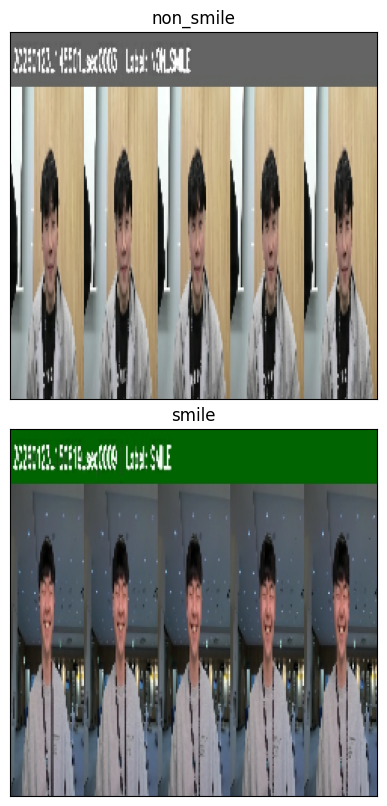

In [8]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8,8),
    subplot_kw={'xticks': [], 'yticks': []}
)

for i, class_idx in enumerate(sorted(class_images.keys())):
    axes[i].imshow(class_images[class_idx].astype("uint8"))
    axes[i].set_title(class_names[class_idx], fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

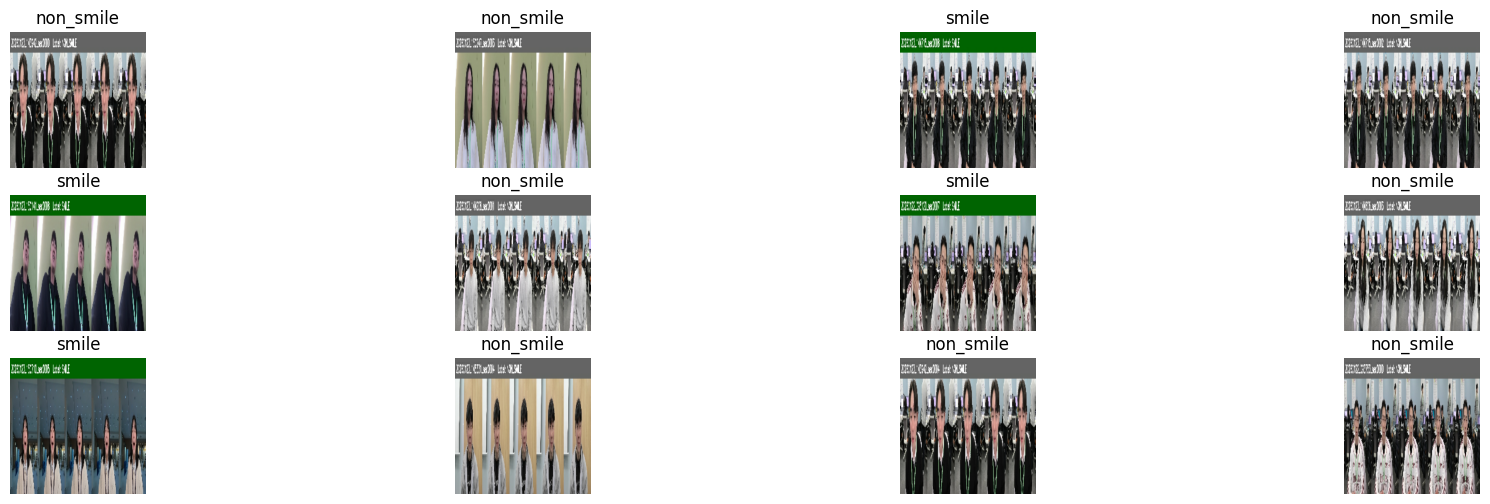

In [9]:
plt.figure(figsize=(22,6))
for image_batch, label_batch in dataset.take(1):

    num_images = min(12, len(image_batch)) 
    
    for i in range(num_images):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])   
        plt.axis('off')

In [10]:
def get_dataset_partitions_tf (ds,train_split=0.6, val_split=0.20, test_split=0.20, shuffle=True,shuffle_size=10000 ):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds 

In [11]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds = train_ds.map(lambda x, y: (x/255,y))
test_ds = test_ds.map(lambda x, y: (x/255,y))
val_ds = val_ds.map(lambda x, y: (x/255,y))

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = test_ds.cache().prefetch(AUTOTUNE)
test_ds = val_ds.cache().prefetch(AUTOTUNE)

In [26]:
for images, _ in dataset.take(1):
    CHANNELS = images.shape[-1]

input_shape = (*IMAGE_SIZE, CHANNELS)


model = models.Sequential([
    layers.Input(shape=input_shape), 
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),   

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
     layers.Dropout(0.2), 
   

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3), 
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation="sigmoid"),
])

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 244, 244, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 244, 244, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 244, 244, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 244, 244, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 122, 122, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 122, 122, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 61, 61, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,673 (471.38 KB)

 Trainable params: 119,905 (468.38 KB)

 Non-trainable params: 768 (3.00 KB)

In [28]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [30]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

In [31]:
history = model.fit(
    train_ds,
    epochs=100,               
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step - accuracy: 0.7594 - loss: 0.5144 - val_accuracy: 0.4429 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0860 - val_accuracy: 0.4857 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0252 - val_accuracy: 0.4857 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.4857 - val_loss: 0.6892 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.4857 - val_loss: 0.6880 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.4857 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy

In [32]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9720 - loss: 0.1037


In [33]:
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Test Accuracy: 95.71%


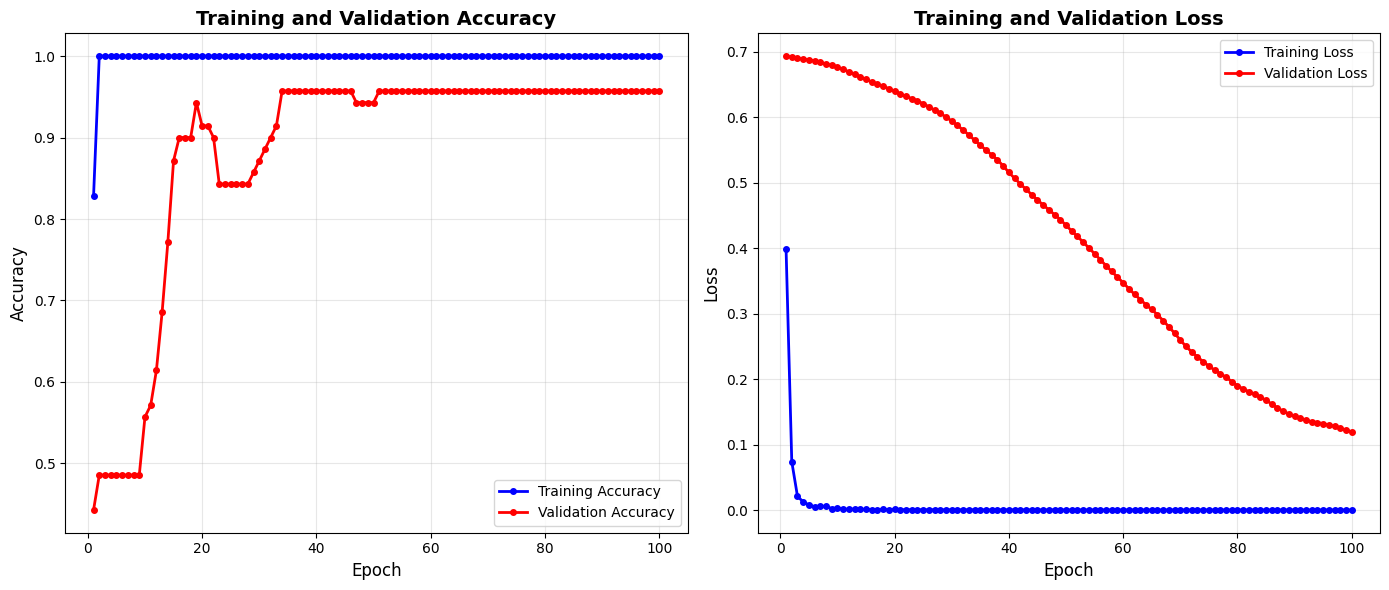


Training Summary:
Total epochs trained: 100
Best validation accuracy: 0.9571 (Epoch 34)
Final training accuracy: 1.0000
Final validation accuracy: 0.9571
Final training loss: 0.0001
Final validation loss: 0.1196



In [34]:
def plot_training_history(history):
    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
  
    total_epochs = len(acc)
    best_epoch = val_acc.index(max(val_acc)) + 1
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Total epochs trained: {total_epochs}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {best_epoch})")
    print(f"Final training accuracy: {acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final training loss: {loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"{'='*50}\n")


plot_training_history(history)